# Setup

In [2]:
!pip install fastai > /dev/null

In [109]:
import pandas as pd

from fastai.tabular.all import *

In [111]:
pd_clean_train = pd.read_csv("./data/clean/train.csv", index_col='PassengerId')
pd_clean_test = pd.read_csv("./data/clean/test.csv", index_col='PassengerId')
pd_sample_submission = pd.read_csv("../input/sample_submission.csv")

In [8]:
pd_clean_train.info()
pd_clean_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S


# Create Modeling Datasets

In [12]:
def format_dataset(pd_df):
    dataset_cols = [
        'Sex', 
        'Ticket', 
        'Cabin', 
        'Embarked', 
        'Pclass',
        'Age',
        'SibSp',
        'Parch',
        'Fare',
        'Survived']
    
    return pd_df.loc[:, [col for col in dataset_cols if col in pd_df.columns]]


def transform_survived_col(pd_df):
    return pd_df.assign(Survived=pd_df.Survived.astype(np.float16))

In [14]:
pd_model_train = (pd_clean_train
    .pipe(transform_survived_col)
    .pipe(format_dataset))
pd_model_test = (pd_clean_test
    .pipe(format_dataset))

# Train-Validation Split

In [15]:
pd_train = pd_model_train.sample(frac = 0.8, random_state=3)
pd_valid = pd_model_train.drop(pd_train.index)

# Create Modeling Dataset

In [16]:
splits = (list(pd_train.index.values), list(pd_valid.index.values))
procs = [Categorify, FillMissing, Normalize]

In [10]:
cat = ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']
cont = [ 'Age', 'SibSp', 'Parch', 'Fare']

In [79]:
tp_train = TabularPandas(
    df=pd_model_train, 
    procs=procs, 
    cat_names=cat, 
    cont_names=cont, 
    y_names='Survived', 
    splits=splits)

In [31]:
print("Unprocessed:")
tp_train.show(1)

Unprocessed:


,Sex,Ticket,Cabin,Embarked,Pclass,Age_na,Fare_na,Age,SibSp,Parch,Fare,Survived
PassengerId,,,,,,,,,,,,
79528,male,467910,#na#,S,3,False,False,23.0,0.0,0.0,26.09,0.0


In [ ]:
# Save


In [ ]:
# Read

# Train Model

In [40]:
# Define model
dls = tp_train.dataloaders(1024)
learner = tabular_learner(
    dls=dls, 
    y_range=(0,1), 
    metrics=accuracy)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.004365158267319202)

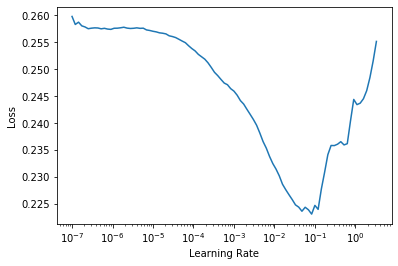

In [41]:
# Find optimal learning rate
learner.lr_find()

In [43]:
# Fit model
learner.fit_one_cycle(3, 0.004365158267319202)

epoch,train_loss,valid_loss,accuracy,time
0,0.183205,0.167300,0.574100,00:42
1,0.090518,0.205924,0.574100,00:35
2,0.050525,0.205658,0.574100,00:35


In [124]:
# Save model
! rm ./models/nn.pth  # remove previously saved model
learner.save('nn')

Path('models/nn.pth')

# Evaluate Model

In [44]:
learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(75332, 600)
    (2): Embedding(26993, 485)
    (3): Embedding(4, 3)
    (4): Embedding(4, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(1104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1104, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=1)
  )
)

# Create Submission

In [ ]:
tp_test = tp_train.new(pd_model_test)
tp_test.process()

In [80]:
tst_dl = dls.valid.new(tp_test)
tst_dl.show_batch()

,Sex,Ticket,Cabin,Embarked,Pclass,Age_na,Fare_na,Age,SibSp,Parch,Fare
0,male,24745,#na#,S,3,False,False,19.000000,8.996231e-09,-1.051629e-08,63.010000
1,female,13264,#na#,S,3,False,False,53.000000,8.996231e-09,-1.051629e-08,5.810002
2,female,25990,B15315,C,1,False,False,19.000000,8.996231e-09,-1.051629e-08,38.910000
3,male,#na#,#na#,S,2,False,False,25.000000,8.996231e-09,-1.051629e-08,12.930000
4,female,26203,B22515,C,1,False,False,17.000001,8.996231e-09,2.000000e+00,26.890000
5,male,#na#,#na#,C,3,False,False,34.000000,8.996231e-09,-1.051629e-08,10.400000
6,female,#na#,#na#,S,1,False,False,48.000000,1.000000e+00,2.000000e+00,221.940004
7,male,#na#,#na#,S,3,False,False,13.000001,8.996231e-09,-1.051629e-08,9.409999
8,female,#na#,#na#,S,3,False,False,15.999999,1.000000e+00,-1.051629e-08,12.309999
9,male,39023,#na#,S,3,False,False,19.999999,8.996231e-09,-1.051629e-08,6.170000


In [83]:
preds, _ = learner.get_preds(dl=tst_dl)

In [99]:
labels = labels = np.argmax(preds, 1)

In [107]:
np.array(labels)

In [90]:
type(preds)

torch.Tensor

In [91]:
type(preds[0])

torch.Tensor

In [96]:
preds[0]

tensor([0.0204])

In [94]:
preds[0][0]

tensor(0.0204)

In [ ]:
dl = model.dls.test_dl(test_data, bs=64) # apply transforms
preds,  _ = model.get_preds(dl=dl) # get prediction

In [54]:
learner

In [69]:
#tp_test.loc[0, :]

In [ ]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

# create submission file to submit in Kaggle competition
submission = pd.DataFrame({'PassengerId': test_id, 'Survived': labels})
submission.to_csv('submission.csv', index=False)
submission.head()

In [64]:
preds, targs = learn.get_preds()

In [81]:
learn.predict()

AttributeError: to_frame

In [102]:
# Create sumbission dataset
predictions = clf.predict(pd_model_test)
#pd_submission = pd_sample_submission.assign(Survived=predictions)
#pd_submission.to_csv('sub-2.0-modelling-xgboost.csv', index=False)